In [1]:
"""
Train a 3d Unet with 128x128x128x3 3D images input and 1D Mask labels output.

data are .npy files in this practice
"""
import os
import numpy as np
import keras
from matplotlib import pyplot as plt
import glob
import random


Num. of images:  344


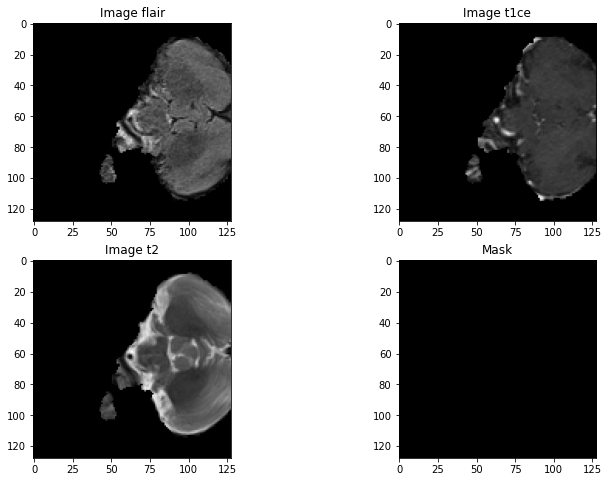

In [2]:
"""
Test reading data.
"""

train_img_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\images\\"
train_mask_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\mask\\"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

print("Num. of images: ", num_images)

img_num = random.randint(0,num_images-1) # randomly load a data
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice], cmap='gray')
plt.title('Mask')
plt.show()


In [3]:
# Set images dir

train_img_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\images\\"
train_mask_dir = "I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\mask\\"

test_img_dir = "I:\\Data\\Brain MRI\\BraTS2020_ValidationData\\input_data_3channels\\images\\"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

test_img_list=os.listdir(test_img_dir)


In [4]:
## Load data

x_train = []
y_train = []

x_test = []

for i in range(int(len(train_img_list)*5/9)):
    temp_img = np.load(train_img_dir+train_img_list[i])
    x_train.append(temp_img)
    
    temp_img = np.load(train_mask_dir+train_mask_list[i])
    y_train.append(temp_img)
    
    
for i in range(int(len(test_img_list)*5/9)):
    temp_img = np.load(test_img_dir+test_img_list[i])
    x_test.append(temp_img)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

print(x_train.shape)

(191, 128, 128, 128, 3)


In [5]:
# Pick the model 
from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

                                64)                                                               
                                                                                                  
 max_pooling3d_6 (MaxPooling3D)  (None, 16, 16, 16,   0          ['conv3d_24[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_25 (Conv3D)             (None, 16, 16, 16,   221312      ['max_pooling3d_6[0][0]']        
                                128)                                                              
                                                                                                  
 dropout_12 (Dropout)           (None, 16, 16, 16,   0           ['conv3d_25[0][0]']              
                                128)                                                              
          

 conv3d_36 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_17[0][0]']             
                                8, 16)                                                            
                                                                                                  
 conv3d_37 (Conv3D)             (None, 128, 128, 12  68          ['conv3d_36[0][0]']              
                                8, 4)                                                             
                                                                                                  
Total params: 5,645,828
Trainable params: 5,645,828
Non-trainable params: 0
__________________________________________________________________________________________________


In [6]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

model.compile(optimizer = keras.optimizers.Adam(0.0001),
              loss = bce_jaccard_loss,
              metrics=[iou_score, 'accuracy'])
# print(model.summary())

print(model.input_shape)
print(model.output_shape)


Segmentation Models: using `keras` framework.
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [7]:
# Train the model

# Model checkpoint
import tensorflow as tf

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_brain_seg.h5', verbose=1, save_best_only=True)

callbacks = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

history=model.fit(x_train,
                  y_train,
                  epochs=100,
                  verbose=1,
                  validation_split=0.1,
                  shuffle=True,
                  batch_size=1,
                  validation_batch_size=1,
                  callbacks=callbacks
                  )


Epoch 1/100
171/171 [==============================] - 3876s 22s/step - loss: 0.9555 - iou_score: 0.2262 - accuracy: 0.9287 - val_loss: 0.9758 - val_iou_score: 0.2160 - val_accuracy: 0.9534
Epoch 2/100
171/171 [==============================] - 3555s 21s/step - loss: 0.8384 - iou_score: 0.2506 - accuracy: 0.9509 - val_loss: 0.9294 - val_iou_score: 0.2291 - val_accuracy: 0.9477
Epoch 3/100
171/171 [==============================] - 3542s 21s/step - loss: 0.7425 - iou_score: 0.3880 - accuracy: 0.9506 - val_loss: 0.7051 - val_iou_score: 0.4331 - val_accuracy: 0.8810
Epoch 4/100
171/171 [==============================] - 3540s 21s/step - loss: 0.5504 - iou_score: 0.5596 - accuracy: 0.9548 - val_loss: 0.6009 - val_iou_score: 0.5072 - val_accuracy: 0.9290
Epoch 5/100
171/171 [==============================] - 3572s 21s/step - loss: 0.5287 - iou_score: 0.5920 - accuracy: 0.9547 - val_loss: 0.6674 - val_iou_score: 0.4712 - val_accuracy: 0.8756
Epoch 6/100
171/171 [=============================

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_1/conv3d_35/Conv3D/Conv3DBackpropInputV2' defined at (most recent call last):
    File "C:\Users\User\anaconda3\myanaconda\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\User\anaconda3\myanaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\User\anaconda3\myanaconda\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\User\anaconda3\myanaconda\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\User\anaconda3\myanaconda\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-7-4c2a46d5f9ae>", line 10, in <module>
      history=model.fit(x_train,
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_1/conv3d_35/Conv3D/Conv3DBackpropInputV2'
OOM when allocating tensor with shape[1,2097152,864] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_1/conv3d_35/Conv3D/Conv3DBackpropInputV2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4091]

In [8]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined